#1-1 学習済みデータセットを用いた推論


In [96]:
import os
import urllib.request
import zipfile

# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)


# ImageNetのclass_indexをダウンロードする
# Kerasで用意されているものです
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)


# 1.3節で使用するアリとハチの画像データをダウンロードし解凍します
# PyTorchのチュートリアルで用意されているものです
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)







In [97]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git


fatal: destination path 'pytorch_advanced' already exists and is not an empty directory.


In [98]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
from torchvision import models,transforms 

In [ ]:
#学習済みモデルロード

#VGG-16モデルのインスタンス生成
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.eval()

print(net)

In [20]:
class BaseTransform():
  """
  画像をリサイズし、色を標準化

  Attributes
  ----------
  resize : int（リサイズ先の画像の大きさ）
  mean : (R,G,B) 各色チャンネルの平均値
  std : (R,G,B) 各色チャンネルの標準偏差
  """
  def __init__(self,resize,mean,std):
    self.base_transform = transforms.Compose([
      transforms.Resize(resize),
      transforms.CenterCrop(resize),
      transforms.ToTensor(),
      transforms.Normalize(mean,std) #色情報の標準化                            
    ])

  def __call__(self,img):
    return self.base_transform(img)  

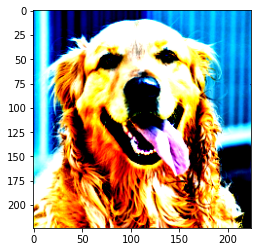

In [ ]:
#画像変形の動作を確認
image_path = "/content/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg"
img = Image.open(image_path)

resize = 224
mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)
transform = BaseTransform(resize,mean,std)
image_tramsformed = transform(img)

img_transformed = image_tramsformed.numpy().transpose(1,2,0)
img_transformed = np.clip(img_transformed,0,1) #0から1に制限
plt.imshow(img_transformed)


In [ ]:
ILSVRC_class_index = json.load(open('/content/data/imagenet_class_index.json','r'))
ILSVRC_class_index

In [ ]:
#出力結果からラベルを予測する
class ILSVRCPredictor():
  """
  ILSVRCデータにに対するモデルの出力からラベルを求める

  Attributes
  ----------
  class_index:dictionary
  """
  def __init__(self,class_index):
    self.class_index = class_index

  def predict_max(self,out):
    """
    確率最大のラベルを出力
    """
    maxid = np.argmax(out.detach().numpy())
    predicted_label_name = self.class_index[str(maxid)][1]
    return predicted_label_name

In [ ]:
predictor = ILSVRCPredictor(ILSVRC_class_index)
transform = BaseTransform(resize,mean,std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0)

out = net(inputs)
result = predictor.predict_max(out)

print(result)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


golden_retriever


#1-2 Pytorchによるディープラーニング実装の流れ

Datasetの作成

In [99]:
import glob
import os.path as osp
import random
from tqdm import tqdm

In [100]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [6]:
#データ前処理クラスを作成
class ImageTransform():
  """
  データを前処理するクラス

  Attribute(__init__の引数になるやつ)
  ---------
  resize: 短辺のサイズ
  mean:(R,G,B)
  std:(R,G,B)
  """

  def __init__(self,resize,mean,std):
    self.data_transform = {
      "train" : transforms.Compose([                               
        transforms.RandomResizedCrop(
            resize,scale=(0.5,1.0)
        ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)                                   
      ]),
      "val": transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)                         
      ])
    }  

  def __call__(self,img,phase='train'):
    return self.data_transform[phase](img)




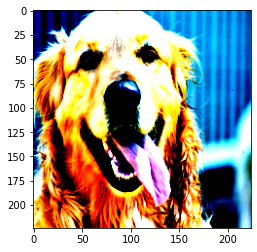

In [7]:
#画像前処理の動作を確認
image_path = '/content/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_path)

resize = 224
mean = mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)
transform = ImageTransform(resize,mean,std)
img_transformed = transform(img,phase = 'train')
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed,0,1)
plt.imshow(img_transformed)

In [8]:
#画像のパスを作るリストを作成
def make_datapath_list(phase='train'):
  """
  引数：phase(train/val)
  ---------------------
  return : path_list

  """
  rootpath = '/content/data/hymenoptera_data/'
  target_path = osp.join(rootpath+phase+'/**/*.jpg')
  

  path_list = []
  for path in glob.glob(target_path):
     path_list.append(path)

  return path_list   


In [ ]:

make_datapath_list(phase='val')[0][35:39]

'bees'

In [9]:
#いよいよデータセットを作っていくよ！
#今まで整備してきたのは…
#データ前処理クラス
#画像パスを取り出す関数

class HymenopteraDataset(data.Dataset): #別のクラスのインスタンス・メソッドをを継承したいなら、ここの引数として渡す！
  """
  アリとハチの画像のDatasetクラス。PythonのDatasetクラスを継承
  Attributes
  ----------
  file_list:画像のパスを格納するリスト
  transform:object 前処理クラスのインスタンス
  phase:'train'/'val' 学習か検証か設定

  """
  def __init__(self,file_list,transform,phase='train'):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self,index):
    #画像取得、前処理
    img_path = self.file_list[index]   
    img = Image.open(img_path) 
    img_transformed = self.transform(img,self.phase)

    #正解ラベルデータ取得・数値に変換
    if self.phase == 'train':
      label = img_path[37:41]
    elif self.phase =='val':
      label = img_path[35:39]

    if label == 'ants':
      label = 0

    elif label == 'bees':
      label = 1

    return img_transformed,label     



In [10]:
#実際にデータを取り出してみよう！
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')
train_dataset = HymenopteraDataset(train_list,transform,phase='train')
val_dataset = HymenopteraDataset(val_list,transform,phase='val')

print(train_dataset.__getitem__(0)[0].size())
print(train_dataset.__getitem__(0)[1])

torch.Size([3, 224, 224])
0


DataLoaderの作成

In [11]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}

#動作確認
batch_iterator = iter(dataloaders_dict['train'])
inputs,labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1])


モデルの作成

In [ ]:
#今回は学習済みVGG-16モデルを使用
#最終出力層だけ変更

use_pretrained = True
net = models.vgg16(pretrained=True)
net.classifier[6] = nn.Linear(in_features=4096,out_features=2)

#訓練モードに
net.train()

損失関数の定義

In [13]:
criterion = nn.CrossEntropyLoss()

最適化手法を定義

In [14]:
net.named_parameters()

<generator object Module.named_parameters at 0x7f508b1976d0>

In [15]:
#今回は転移学習をするので、最終層のパラメータだけ勾配計算に加える
params_to_update=[]
update_param_names = ["classifier.6.weight","classifier.6.bias"]

for name,param in net.named_parameters():
  if name in update_param_names:
    param.requires_grad = True
    print(name)
    params_to_update.append(param)
  else:
    param.requires_grad = False



classifier.6.weight
classifier.6.bias


In [16]:
optimizer = optim.SGD(params=params_to_update,lr=0.001,momentum=0.9)

学習・検証

In [17]:
#訓練用の関数

def train_model(net,dataloaders_dict,criterion,optimizer,num_epochs):
  for epoch in range(num_epochs):
    print("Epoch:{}/{}".format(epoch+1,num_epochs))
    print("======================================")

    for phase in ["train","val"]:
      if phase == "train":
        net.train() #訓練モードに
      else:
        net.eval() #検証モードに

      epoch_loss = 0.0 #epochの損失和
      epoch_corrects = 0 #epochの正解数

      #未学習時の検証性能を確かめるため、epoch=0の訓練は省略
      if (epoch == 0) and (phase == 'train'): 
        continue
      #データローダからミニバッチを取り出すループ
      for inputs,labels in tqdm(dataloaders_dict[phase]):
        #勾配初期化
        optimizer.zero_grad()

        #順伝播(forward)計算
        with torch.set_grad_enabled(phase=='train'):
          outputs = net(inputs) #model(入力)で順伝播してくれるやつ
          loss = criterion(outputs,labels) #nn.criterion(出力、正解ラベル)
          _,preds = torch.max(outputs,1) #なんだこれ（出力(,2)からラベル返すやつ）

          #訓練時のみ逆伝播
          if phase == 'train':
            loss.backward()
            optimizer.step() #optimizer.stepでパラメータを更新する


          #iteration結果の計算
          #loss合計を更新（なんでepoch全体で足してるんだ？？）
          epoch_loss += loss.item()*inputs.size(0)
          """
          ここでなにしてるのかと言いますと
          モチベーションとしては
          "epochごとのlossの総和を取りたい！！"
          そのために、各iterationごとに
          "バッチごとのlossの平均"* "バッチ数"をたしあわせている
          """
          #正解数の合計を更新
          epoch_corrects += torch.sum(preds==labels.data)

      #epochごとのlossと正解率を表示
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset) #損失平均
      #1epochは、バッチ抽出を繰り返してのべdataset全体と同じ枚数を抽出した時の回数だから
      epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))






In [ ]:
#実行！！！
num_epochs = 2
train_model(net,dataloaders_dict,criterion,optimizer,num_epochs)

Epoch:1/2


 20%|██        | 1/5 [00:29<01:57, 29.31s/it]


KeyboardInterrupt: ignored

##GPUを使った学習の実装

休憩おわり
ねー1から学習するのってどーやるんだろーね
ってことでやってみようー


In [ ]:
models.resnet34()

In [ ]:
#とりあえずmodelとoptimizerは変える必要 is ありそう
#ランタイプをGPUにするの忘れない
net2 = models.resnet34(pretrained = False)
net2.fc = nn.Linear(in_features=512,out_features=2)

In [ ]:
optimizer = optim.Adam(net2.parameters())


In [ ]:
#訓練なう
num_epochs = 10
train_model(net2,dataloaders_dict,criterion,optimizer,num_epochs)

Epoch:1/10


 20%|██        | 1/5 [00:04<00:18,  4.66s/it]

val Loss: 0.0000 Acc: 0.2092


 20%|██        | 1/5 [00:06<00:24,  6.13s/it]


KeyboardInterrupt: ignored

回してる間暇だからちゃんとしたやつ実装する

In [18]:
import torch.nn.functional as F

In [21]:
resize = 28
mean = (0.485)
std = (0.225)
transform_mnist = BaseTransform(resize,mean,std)

In [22]:
#なんもわからん
#とりまデータセットいるよな
#なんにしよう
# Mnist? （なにも思いつかない…）ImageNetのやつでもいいか…
#Mnist ならこんな大きいモデルいらんのよな

#結局ResNetでMnistやってみることにする（大袈裟）
#valデータめんどくさかったのでtestで代用（だめ）
train_size = 48000
val_size = 12000

trainval_set = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform_mnist)

trainset, valset = torch.utils.data.random_split(trainval_set, [train_size, val_size])

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform_mnist)

mnistdataloader_train = torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
mnistdataloader_val = torch.utils.data.DataLoader(valset,batch_size=32,shuffle=False)
mnist_dataloader_dict = {"train":mnistdataloader_train,"val":mnistdataloader_val}


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [23]:
net_formnist = models.resnet34(pretrained = False)
net_formnist.fc = nn.Linear(in_features=512,out_features=10)
optimizer = optim.Adam(net_formnist.parameters())


In [ ]:
#訓練なう
num_epochs = 2
train_model(net2,dataloaders_dict,criterion,optimizer,num_epochs)

NameError: ignored

In [24]:
#なんかMnistでResNetやんのなんか微妙なので自分でNet組んだ（しょぼいやつ）
class Net(nn.Module):
  def __init__(self): #層をインスタンス化
    super(Net,self).__init__() #継承したnn.Modelの初期化関数を起動
    self.conv1 = nn.Conv2d(1,32,3) #チャネル数in_features=1（白黒なのでそれはそう),out_features=32,フィルター3×3
    self.conv2 = nn.Conv2d(32,64,3) 
    self.pool = nn.MaxPool2d(2,2)
    self.dropout1 = nn.Dropout2d()
    self.fc1 = nn.Linear(in_features=12*12*64,out_features=128)
    self.dropout2 = nn.Dropout2d()
    self.fc2 = nn.Linear(128,10)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout1(x)
    x = x.view(-1,12*12*64)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = self.fc2(x)
    return x 



In [25]:
net_mnist = Net()
net_mnist.parameters()

<generator object Module.parameters at 0x7f508a6bd3d0>

In [26]:

optimizer = optim.SGD(net_mnist.parameters(),lr=0.0001)

In [28]:
num_epochs = 30
train_model(net_mnist,mnist_dataloader_dict,criterion,optimizer,num_epochs=30)

Epoch:1/30


100%|██████████| 375/375 [00:13<00:00, 28.68it/s]


val Loss: 0.4468 Acc: 0.8831
Epoch:2/30


100%|██████████| 1500/1500 [02:00<00:00, 12.45it/s]


train Loss: 0.6131 Acc: 0.8234


100%|██████████| 375/375 [00:13<00:00, 28.80it/s]


val Loss: 0.4172 Acc: 0.8871
Epoch:3/30


100%|██████████| 1500/1500 [01:59<00:00, 12.53it/s]


train Loss: 0.5778 Acc: 0.8339


100%|██████████| 375/375 [00:13<00:00, 28.84it/s]


val Loss: 0.3941 Acc: 0.8906
Epoch:4/30


100%|██████████| 1500/1500 [01:59<00:00, 12.55it/s]


train Loss: 0.5512 Acc: 0.8430


100%|██████████| 375/375 [00:12<00:00, 29.33it/s]


val Loss: 0.3750 Acc: 0.8942
Epoch:5/30


100%|██████████| 1500/1500 [01:58<00:00, 12.64it/s]


train Loss: 0.5295 Acc: 0.8452


100%|██████████| 375/375 [00:12<00:00, 29.57it/s]


val Loss: 0.3619 Acc: 0.8949
Epoch:6/30


100%|██████████| 1500/1500 [01:58<00:00, 12.67it/s]


train Loss: 0.5136 Acc: 0.8512


100%|██████████| 375/375 [00:12<00:00, 29.75it/s]


val Loss: 0.3475 Acc: 0.8994
Epoch:7/30


100%|██████████| 1500/1500 [01:56<00:00, 12.88it/s]


train Loss: 0.4926 Acc: 0.8584


100%|██████████| 375/375 [00:12<00:00, 29.89it/s]


val Loss: 0.3344 Acc: 0.9030
Epoch:8/30


100%|██████████| 1500/1500 [01:56<00:00, 12.87it/s]


train Loss: 0.4798 Acc: 0.8622


100%|██████████| 375/375 [00:12<00:00, 29.80it/s]


val Loss: 0.3261 Acc: 0.9048
Epoch:9/30


100%|██████████| 1500/1500 [01:59<00:00, 12.59it/s]


train Loss: 0.4661 Acc: 0.8670


100%|██████████| 375/375 [00:12<00:00, 29.30it/s]


val Loss: 0.3164 Acc: 0.9062
Epoch:10/30


100%|██████████| 1500/1500 [01:59<00:00, 12.60it/s]


train Loss: 0.4540 Acc: 0.8690


100%|██████████| 375/375 [00:12<00:00, 29.03it/s]


val Loss: 0.3092 Acc: 0.9078
Epoch:11/30


100%|██████████| 1500/1500 [01:56<00:00, 12.85it/s]


train Loss: 0.4402 Acc: 0.8721


100%|██████████| 375/375 [00:12<00:00, 30.22it/s]


val Loss: 0.3012 Acc: 0.9093
Epoch:12/30


100%|██████████| 1500/1500 [01:56<00:00, 12.91it/s]


train Loss: 0.4341 Acc: 0.8762


100%|██████████| 375/375 [00:12<00:00, 30.06it/s]


val Loss: 0.2933 Acc: 0.9105
Epoch:13/30


100%|██████████| 1500/1500 [01:54<00:00, 13.07it/s]


train Loss: 0.4233 Acc: 0.8790


100%|██████████| 375/375 [00:11<00:00, 31.52it/s]


val Loss: 0.2876 Acc: 0.9139
Epoch:14/30


100%|██████████| 1500/1500 [01:54<00:00, 13.09it/s]


train Loss: 0.4099 Acc: 0.8815


100%|██████████| 375/375 [00:12<00:00, 30.16it/s]


val Loss: 0.2795 Acc: 0.9144
Epoch:15/30


100%|██████████| 1500/1500 [01:56<00:00, 12.83it/s]


train Loss: 0.4100 Acc: 0.8835


100%|██████████| 375/375 [00:12<00:00, 29.64it/s]


val Loss: 0.2768 Acc: 0.9155
Epoch:16/30


100%|██████████| 1500/1500 [01:55<00:00, 12.98it/s]


train Loss: 0.3969 Acc: 0.8868


100%|██████████| 375/375 [00:12<00:00, 30.40it/s]


val Loss: 0.2691 Acc: 0.9181
Epoch:17/30


100%|██████████| 1500/1500 [01:55<00:00, 12.98it/s]


train Loss: 0.3892 Acc: 0.8883


100%|██████████| 375/375 [00:12<00:00, 30.31it/s]


val Loss: 0.2647 Acc: 0.9195
Epoch:18/30


100%|██████████| 1500/1500 [01:55<00:00, 12.94it/s]


train Loss: 0.3831 Acc: 0.8909


100%|██████████| 375/375 [00:12<00:00, 30.06it/s]


val Loss: 0.2610 Acc: 0.9211
Epoch:19/30


100%|██████████| 1500/1500 [01:56<00:00, 12.92it/s]


train Loss: 0.3799 Acc: 0.8906


100%|██████████| 375/375 [00:12<00:00, 29.83it/s]


val Loss: 0.2568 Acc: 0.9227
Epoch:20/30


100%|██████████| 1500/1500 [01:59<00:00, 12.56it/s]


train Loss: 0.3713 Acc: 0.8927


100%|██████████| 375/375 [00:12<00:00, 30.58it/s]


val Loss: 0.2509 Acc: 0.9243
Epoch:21/30


100%|██████████| 1500/1500 [01:58<00:00, 12.63it/s]


train Loss: 0.3647 Acc: 0.8941


100%|██████████| 375/375 [00:12<00:00, 29.92it/s]


val Loss: 0.2465 Acc: 0.9244
Epoch:22/30


100%|██████████| 1500/1500 [02:04<00:00, 12.01it/s]


train Loss: 0.3633 Acc: 0.8978


100%|██████████| 375/375 [00:13<00:00, 28.79it/s]


val Loss: 0.2434 Acc: 0.9258
Epoch:23/30


100%|██████████| 1500/1500 [02:04<00:00, 12.07it/s]


train Loss: 0.3523 Acc: 0.8984


100%|██████████| 375/375 [00:13<00:00, 28.05it/s]


val Loss: 0.2396 Acc: 0.9278
Epoch:24/30


100%|██████████| 1500/1500 [02:04<00:00, 12.08it/s]


train Loss: 0.3463 Acc: 0.8999


100%|██████████| 375/375 [00:12<00:00, 29.51it/s]


val Loss: 0.2340 Acc: 0.9277
Epoch:25/30


100%|██████████| 1500/1500 [02:02<00:00, 12.27it/s]


train Loss: 0.3440 Acc: 0.9019


100%|██████████| 375/375 [00:12<00:00, 30.76it/s]


val Loss: 0.2339 Acc: 0.9284
Epoch:26/30


100%|██████████| 1500/1500 [01:59<00:00, 12.60it/s]


train Loss: 0.3391 Acc: 0.9028


100%|██████████| 375/375 [00:12<00:00, 30.40it/s]


val Loss: 0.2299 Acc: 0.9300
Epoch:27/30


100%|██████████| 1500/1500 [01:59<00:00, 12.58it/s]


train Loss: 0.3366 Acc: 0.9040


100%|██████████| 375/375 [00:12<00:00, 30.95it/s]


val Loss: 0.2253 Acc: 0.9317
Epoch:28/30


100%|██████████| 1500/1500 [02:04<00:00, 12.03it/s]


train Loss: 0.3305 Acc: 0.9050


100%|██████████| 375/375 [00:13<00:00, 28.81it/s]


val Loss: 0.2211 Acc: 0.9336
Epoch:29/30


100%|██████████| 1500/1500 [02:05<00:00, 11.94it/s]


train Loss: 0.3255 Acc: 0.9069


100%|██████████| 375/375 [00:13<00:00, 27.93it/s]


val Loss: 0.2213 Acc: 0.9338
Epoch:30/30


100%|██████████| 1500/1500 [02:03<00:00, 12.11it/s]


train Loss: 0.3207 Acc: 0.9091


100%|██████████| 375/375 [00:12<00:00, 29.68it/s]

val Loss: 0.2161 Acc: 0.9354


この学習済みモデルを使って早押し機を作っていくっ


In [72]:
def predict(input,net):
  out = net(input)
  #softmaxを入れる
  out = torch.exp(out)/torch.sum(torch.exp(out))
  pred = int(torch.argmax(out))
  if out[0][pred] >= 0.5:
    return pred
  else:
    return -1  


In [ ]:
testset[1][0].unsqueeze_(0).size()

torch.Size([1, 1, 28, 28])

In [ ]:
question_1 = testset[1][0].unsqueeze_(0)
print(predict(question_1,net_mnist))

2


In [73]:
for i in range(10):
  print("======= question {} =======".format(i+1))
  question = testset[i][0].unsqueeze_(0)
  print("Answer is:",predict(question,net_mnist))
  print("The right answer is:",testset[i][1])


======= question 1 =======
Answer is: 7
The right answer is: 7
======= question 2 =======
Answer is: 2
The right answer is: 2
======= question 3 =======
Answer is: 1
The right answer is: 1
======= question 4 =======
Answer is: 0
The right answer is: 0
======= question 5 =======
Answer is: 4
The right answer is: 4
======= question 6 =======
Answer is: 1
The right answer is: 1
======= question 7 =======
Answer is: 4
The right answer is: 4
======= question 8 =======
Answer is: 9
The right answer is: 9
======= question 9 =======
Answer is: 6
The right answer is: 5
======= question 10 =======
Answer is: 9
The right answer is: 9


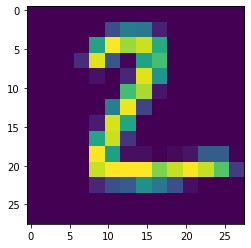

In [ ]:
#テストデータの解像度下げれんかな
img_1 = testset[1][0]
img_1 = img_1.numpy().transpose((1,2,0)).reshape(28,28)
#print(img_1)
#こっから解像度下げるアルゴリズム…めんどくさい…
img_1dash = np.zeros((28,28))
for i in range(14):
  for j in range(14):
    img_1dash[2*i][2*j] = (img_1[2*i][2*j]+img_1[2*i+1][2*j]+img_1[2*i][2*j+1]+img_1[2*i+1][2*j+1])/4    
    img_1dash[2*i+1][2*j] = (img_1[2*i][2*j]+img_1[2*i+1][2*j]+img_1[2*i][2*j+1]+img_1[2*i+1][2*j+1])/4    
    img_1dash[2*i][2*j+1] = (img_1[2*i][2*j]+img_1[2*i+1][2*j]+img_1[2*i][2*j+1]+img_1[2*i+1][2*j+1])/4    
    img_1dash[2*i+1][2*j+1] = (img_1[2*i][2*j]+img_1[2*i+1][2*j]+img_1[2*i][2*j+1]+img_1[2*i+1][2*j+1])/4    
img_1dash = torch.from_numpy(img_1dash.astype(np.float32)).clone()
plt.imshow(img_1dash)

In [ ]:

print(predict(img_1dash.unsqueeze_(0).unsqueeze_(0),net_mnist))

2


In [ ]:
#テストデータの解像度下げれんかな
img_1 = testset[1][0]
img_1 = img_1.numpy().transpose((1,2,0)).reshape(28,28)
#print(img_1)
#こっから解像度下げるアルゴリズム…めんどくさい…
img_1dash = np.zeros((28,28))
for i in range(14):
  for j in range(14):
    img_1dash[2*i][2*j] = (img_1[2*i][2*j]+img_1[2*i+1][2*j]+img_1[2*i][2*j+1]+img_1[2*i+1][2*j+1])/4    
    img_1dash[2*i+1][2*j] = (img_1[2*i][2*j]+img_1[2*i+1][2*j]+img_1[2*i][2*j+1]+img_1[2*i+1][2*j+1])/4    
    img_1dash[2*i][2*j+1] = (img_1[2*i][2*j]+img_1[2*i+1][2*j]+img_1[2*i][2*j+1]+img_1[2*i+1][2*j+1])/4    
    img_1dash[2*i+1][2*j+1] = (img_1[2*i][2*j]+img_1[2*i+1][2*j]+img_1[2*i][2*j+1]+img_1[2*i+1][2*j+1])/4 
    
       
img_1dash = torch.from_numpy(img_1dash.astype(np.float32)).clone()
plt.imshow(img_1dash)

In [31]:
#テストデータの解像度下げれんかな
img_1 = testset[1][0]
print(img_1.size())
#こっから解像度下げるアルゴリズム…めんどくさい…

torch.Size([1, 28, 28])


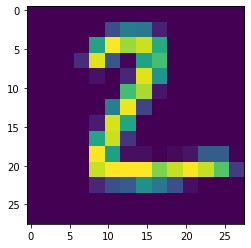

In [34]:
def down_resolution(img_tensor,filter_size):
  """
  img_tensor:(1,28,28)の画像テンソル
  filter_size:filter_size×filter_size ピクセルをひとまとまりにする
  """
  img_arr = img_tensor.numpy().transpose((1,2,0)).reshape(28,28)
  img_dash = np.zeros((28,28))
  for i in range(28//filter_size):
    for j in range(28//filter_size):
      filter_total = 0
      for k in range(filter_size):
        for l in range(filter_size):
          filter_total += img_arr[filter_size*i+k][filter_size*j+l]
      filter_average = filter_total/(filter_size*filter_size)
      for k_ in range(filter_size):
        for l_ in range(filter_size):
          img_dash[filter_size*i+k_][filter_size*j+l_] = filter_average
   
  img_dash = torch.from_numpy(img_dash.astype(np.float32)).clone().unsqueeze_(0)

  return img_dash

plt.imshow(down_resolution(img_1,filter_size=2).reshape(28,28))

In [77]:
for i in range(10):
  print("======= question {} =======".format(i+1))
  question = testset[i][0]
  question_ = down_resolution(question,filter_size=7).unsqueeze_(0)
  print("Answer is:",predict(question_,net_mnist))
  print("The right answer is:",testset[i][1])


======= question 1 =======
Answer is: 7
The right answer is: 7
======= question 2 =======
Answer is: -1
The right answer is: 2
======= question 3 =======
Answer is: -1
The right answer is: 1
======= question 4 =======
Answer is: -1
The right answer is: 0
======= question 5 =======
Answer is: -1
The right answer is: 4
======= question 6 =======
Answer is: -1
The right answer is: 1
======= question 7 =======
Answer is: 7
The right answer is: 4
======= question 8 =======
Answer is: -1
The right answer is: 9
======= question 9 =======
Answer is: 6
The right answer is: 5
======= question 10 =======
Answer is: -1
The right answer is: 9


##解像度が低いやつをデータに組み込む

In [101]:
#Transformを工夫して、学習データに解像度が低いやつを組み込めないか？
#画像前処理クラスを定義
#解像度ダウンのデータを追加
def down_resolution(img_tensor,filter_size):
  """
  img_tensor:(1,28,28)の画像テンソル
  filter_size:filter_size×filter_size ピクセルをひとまとまりにする
  """
  img_arr = img_tensor.numpy().transpose((1,2,0)).reshape(28,28)
  img_dash = np.zeros((28,28))
  for i in range(28//filter_size):
    for j in range(28//filter_size):
      filter_total = 0
      for k in range(filter_size):
        for l in range(filter_size):
          filter_total += img_arr[filter_size*i+k][filter_size*j+l]
      filter_average = filter_total/(filter_size*filter_size)
      for k_ in range(filter_size):
        for l_ in range(filter_size):
          img_dash[filter_size*i+k_][filter_size*j+l_] = filter_average
   
  img_dash = torch.from_numpy(img_dash.astype(np.float32)).clone().unsqueeze_(0)

  return img_dash


In [102]:
def random_down_resolution(img_tensor):
    filter_size = random.choice([1,2,4,7])
    return down_resolution(img_tensor,filter_size)


In [103]:
class MnistTransform():
    def __init__(self,phase='train'): 
        if phase =='train':
            self.transform = \
                torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Lambda(random_down_resolution)
                ])
        elif phase == "val":
            self.transform = \
                torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
            ])
        

    def __call__(self,img):
        return self.transform(img)

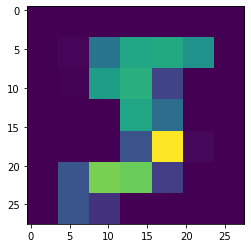

In [104]:
#データを取得
dataset1 = torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=MnistTransform("train"))
dataset2 = torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=MnistTransform("val"))
train_dataset = data.Subset(dataset1,list(range(48000)))
val_dataset = data.Subset(dataset2,list(range(48000,60000)))
test_dataset = torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=MnistTransform())

img_tensor = train_dataset[0][0]
img_transformed = img_tensor.numpy().transpose((1,2,0))
plt.imshow(img_transformed.reshape(28,28))


In [105]:
#dataloaderを作ったった
mnist_dataloader_dict = {
    "train":data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True),
    "val":data.DataLoader(dataset=val_dataset,batch_size=32,shuffle=False)
}

In [106]:
#model作ったった
class MnistNet(nn.Module):
  def __init__(self): #層をインスタンス化
    super().__init__() #継承したnn.Modelの初期化関数を起動
    self.conv1 = nn.Conv2d(1,32,3) #チャネル数in_features=1（白黒なのでそれはそう),out_features=32,フィルター3×3
    self.conv2 = nn.Conv2d(32,64,3) 
    self.pool = nn.MaxPool2d(2,2)
    self.dropout1 = nn.Dropout2d()
    self.fc1 = nn.Linear(in_features=12*12*64,out_features=128)
    self.dropout2 = nn.Dropout2d()
    self.fc2 = nn.Linear(128,10)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout1(x)
    x = x.view(-1,12*12*64)
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)
    x = self.fc2(x)
    return x 

In [107]:
net = MnistNet()

In [108]:
#損失関数作ったった
criterion_mnist = nn.CrossEntropyLoss()

In [109]:
#最適化したった
optimizer = optim.SGD(params=net.parameters(),lr=0.0001)

In [110]:
#訓練なう
num_epochs = 40
train_model(net,mnist_dataloader_dict,criterion_mnist,optimizer,num_epochs)

Epoch:1/40


100%|██████████| 375/375 [00:10<00:00, 35.66it/s]


val Loss: 2.3048 Acc: 0.0882
Epoch:2/40


100%|██████████| 1500/1500 [03:35<00:00,  6.98it/s]


train Loss: 2.3029 Acc: 0.0907


100%|██████████| 375/375 [00:11<00:00, 33.20it/s]


val Loss: 2.2984 Acc: 0.1024
Epoch:3/40


100%|██████████| 1500/1500 [03:35<00:00,  6.97it/s]


train Loss: 2.2990 Acc: 0.1054


100%|██████████| 375/375 [00:10<00:00, 34.47it/s]


val Loss: 2.2922 Acc: 0.1138
Epoch:4/40


100%|██████████| 1500/1500 [03:36<00:00,  6.92it/s]


train Loss: 2.2945 Acc: 0.1270


100%|██████████| 375/375 [00:10<00:00, 34.24it/s]


val Loss: 2.2850 Acc: 0.1985
Epoch:5/40


100%|██████████| 1500/1500 [03:35<00:00,  6.97it/s]


train Loss: 2.2904 Acc: 0.1476


100%|██████████| 375/375 [00:11<00:00, 33.03it/s]


val Loss: 2.2773 Acc: 0.3747
Epoch:6/40


100%|██████████| 1500/1500 [03:40<00:00,  6.81it/s]


train Loss: 2.2846 Acc: 0.1824


100%|██████████| 375/375 [00:11<00:00, 33.17it/s]


val Loss: 2.2681 Acc: 0.5696
Epoch:7/40


100%|██████████| 1500/1500 [03:38<00:00,  6.87it/s]


train Loss: 2.2779 Acc: 0.2127


100%|██████████| 375/375 [00:11<00:00, 32.97it/s]


val Loss: 2.2570 Acc: 0.6602
Epoch:8/40


100%|██████████| 1500/1500 [03:36<00:00,  6.92it/s]


train Loss: 2.2698 Acc: 0.2440


100%|██████████| 375/375 [00:11<00:00, 32.53it/s]


val Loss: 2.2431 Acc: 0.7000
Epoch:9/40


100%|██████████| 1500/1500 [03:35<00:00,  6.97it/s]


train Loss: 2.2594 Acc: 0.2797


100%|██████████| 375/375 [00:11<00:00, 33.70it/s]


val Loss: 2.2257 Acc: 0.7109
Epoch:10/40


100%|██████████| 1500/1500 [03:36<00:00,  6.94it/s]


train Loss: 2.2472 Acc: 0.3089


100%|██████████| 375/375 [00:10<00:00, 34.46it/s]


val Loss: 2.2035 Acc: 0.7109
Epoch:11/40


100%|██████████| 1500/1500 [03:34<00:00,  6.98it/s]


train Loss: 2.2294 Acc: 0.3391


100%|██████████| 375/375 [00:10<00:00, 35.06it/s]


val Loss: 2.1746 Acc: 0.7145
Epoch:12/40


100%|██████████| 1500/1500 [03:34<00:00,  6.99it/s]


train Loss: 2.2086 Acc: 0.3657


100%|██████████| 375/375 [00:10<00:00, 34.36it/s]


val Loss: 2.1371 Acc: 0.7195
Epoch:13/40


100%|██████████| 1500/1500 [03:36<00:00,  6.92it/s]


train Loss: 2.1788 Acc: 0.3980


100%|██████████| 375/375 [00:10<00:00, 34.23it/s]


val Loss: 2.0871 Acc: 0.7202
Epoch:14/40


100%|██████████| 1500/1500 [03:35<00:00,  6.97it/s]


train Loss: 2.1395 Acc: 0.4259


100%|██████████| 375/375 [00:11<00:00, 33.90it/s]


val Loss: 2.0194 Acc: 0.7257
Epoch:15/40


100%|██████████| 1500/1500 [03:34<00:00,  7.01it/s]


train Loss: 2.0872 Acc: 0.4510


100%|██████████| 375/375 [00:10<00:00, 34.44it/s]


val Loss: 1.9271 Acc: 0.7324
Epoch:16/40


100%|██████████| 1500/1500 [03:34<00:00,  7.00it/s]


train Loss: 2.0150 Acc: 0.4775


100%|██████████| 375/375 [00:10<00:00, 34.66it/s]


val Loss: 1.8022 Acc: 0.7447
Epoch:17/40


100%|██████████| 1500/1500 [03:33<00:00,  7.03it/s]


train Loss: 1.9199 Acc: 0.5012


100%|██████████| 375/375 [00:10<00:00, 35.16it/s]


val Loss: 1.6402 Acc: 0.7538
Epoch:18/40


100%|██████████| 1500/1500 [03:29<00:00,  7.15it/s]


train Loss: 1.7989 Acc: 0.5277


100%|██████████| 375/375 [00:10<00:00, 35.74it/s]


val Loss: 1.4475 Acc: 0.7676
Epoch:19/40


100%|██████████| 1500/1500 [03:30<00:00,  7.13it/s]


train Loss: 1.6640 Acc: 0.5514


100%|██████████| 375/375 [00:10<00:00, 35.39it/s]


val Loss: 1.2453 Acc: 0.7837
Epoch:20/40


100%|██████████| 1500/1500 [03:27<00:00,  7.23it/s]


train Loss: 1.5306 Acc: 0.5752


100%|██████████| 375/375 [00:10<00:00, 35.55it/s]


val Loss: 1.0613 Acc: 0.7930
Epoch:21/40


100%|██████████| 1500/1500 [03:31<00:00,  7.10it/s]


train Loss: 1.4014 Acc: 0.6013


100%|██████████| 375/375 [00:10<00:00, 35.32it/s]


val Loss: 0.9089 Acc: 0.8108
Epoch:22/40


100%|██████████| 1500/1500 [03:30<00:00,  7.13it/s]


train Loss: 1.2986 Acc: 0.6198


100%|██████████| 375/375 [00:10<00:00, 35.05it/s]


val Loss: 0.7931 Acc: 0.8244
Epoch:23/40


100%|██████████| 1500/1500 [03:30<00:00,  7.14it/s]


train Loss: 1.2093 Acc: 0.6402


100%|██████████| 375/375 [00:10<00:00, 35.33it/s]


val Loss: 0.7039 Acc: 0.8357
Epoch:24/40


100%|██████████| 1500/1500 [03:32<00:00,  7.06it/s]


train Loss: 1.1405 Acc: 0.6580


100%|██████████| 375/375 [00:10<00:00, 34.98it/s]


val Loss: 0.6389 Acc: 0.8427
Epoch:25/40


100%|██████████| 1500/1500 [03:33<00:00,  7.01it/s]


train Loss: 1.0772 Acc: 0.6741


100%|██████████| 375/375 [00:10<00:00, 35.32it/s]


val Loss: 0.5869 Acc: 0.8498
Epoch:26/40


100%|██████████| 1500/1500 [03:32<00:00,  7.07it/s]


train Loss: 1.0279 Acc: 0.6887


100%|██████████| 375/375 [00:10<00:00, 35.78it/s]


val Loss: 0.5473 Acc: 0.8562
Epoch:27/40


100%|██████████| 1500/1500 [03:29<00:00,  7.16it/s]


train Loss: 0.9842 Acc: 0.6980


100%|██████████| 375/375 [00:10<00:00, 35.89it/s]


val Loss: 0.5137 Acc: 0.8626
Epoch:28/40


100%|██████████| 1500/1500 [03:27<00:00,  7.22it/s]


train Loss: 0.9535 Acc: 0.7091


100%|██████████| 375/375 [00:10<00:00, 35.94it/s]


val Loss: 0.4888 Acc: 0.8665
Epoch:29/40


100%|██████████| 1500/1500 [03:26<00:00,  7.28it/s]


train Loss: 0.9240 Acc: 0.7173


100%|██████████| 375/375 [00:09<00:00, 37.50it/s]


val Loss: 0.4676 Acc: 0.8712
Epoch:30/40


100%|██████████| 1500/1500 [03:27<00:00,  7.23it/s]


train Loss: 0.8956 Acc: 0.7280


100%|██████████| 375/375 [00:10<00:00, 36.78it/s]


val Loss: 0.4495 Acc: 0.8734
Epoch:31/40


100%|██████████| 1500/1500 [03:26<00:00,  7.28it/s]


train Loss: 0.8770 Acc: 0.7328


100%|██████████| 375/375 [00:10<00:00, 36.30it/s]


val Loss: 0.4343 Acc: 0.8783
Epoch:32/40


100%|██████████| 1500/1500 [03:36<00:00,  6.94it/s]


train Loss: 0.8530 Acc: 0.7411


100%|██████████| 375/375 [00:11<00:00, 33.82it/s]


val Loss: 0.4223 Acc: 0.8802
Epoch:33/40


100%|██████████| 1500/1500 [03:37<00:00,  6.91it/s]


train Loss: 0.8403 Acc: 0.7427


100%|██████████| 375/375 [00:11<00:00, 33.77it/s]


val Loss: 0.4099 Acc: 0.8837
Epoch:34/40


100%|██████████| 1500/1500 [03:36<00:00,  6.94it/s]


train Loss: 0.8197 Acc: 0.7485


100%|██████████| 375/375 [00:10<00:00, 35.07it/s]


val Loss: 0.3991 Acc: 0.8864
Epoch:35/40


100%|██████████| 1500/1500 [03:35<00:00,  6.98it/s]


train Loss: 0.8112 Acc: 0.7570


100%|██████████| 375/375 [00:10<00:00, 35.35it/s]


val Loss: 0.3907 Acc: 0.8874
Epoch:36/40


100%|██████████| 1500/1500 [03:31<00:00,  7.08it/s]


train Loss: 0.7968 Acc: 0.7605


100%|██████████| 375/375 [00:10<00:00, 34.56it/s]


val Loss: 0.3820 Acc: 0.8886
Epoch:37/40


100%|██████████| 1500/1500 [03:34<00:00,  7.00it/s]


train Loss: 0.7834 Acc: 0.7607


100%|██████████| 375/375 [00:10<00:00, 35.33it/s]


val Loss: 0.3749 Acc: 0.8907
Epoch:38/40


100%|██████████| 1500/1500 [03:33<00:00,  7.02it/s]


train Loss: 0.7688 Acc: 0.7669


100%|██████████| 375/375 [00:10<00:00, 35.55it/s]


val Loss: 0.3680 Acc: 0.8928
Epoch:39/40


100%|██████████| 1500/1500 [03:36<00:00,  6.94it/s]


train Loss: 0.7610 Acc: 0.7692


100%|██████████| 375/375 [00:11<00:00, 33.01it/s]


val Loss: 0.3630 Acc: 0.8926
Epoch:40/40


100%|██████████| 1500/1500 [03:38<00:00,  6.88it/s]


train Loss: 0.7529 Acc: 0.7714


100%|██████████| 375/375 [00:11<00:00, 32.68it/s]

val Loss: 0.3576 Acc: 0.8938


In [114]:
for i in range(10):
  print("======= question {} =======".format(i+1))
  question = test_dataset[i][0]
  question_ = down_resolution(question,filter_size=1).unsqueeze_(0)
  print("Answer is:",predict(question_,net))
  print("The right answer is:",testset[i][1])


======= question 1 =======
Answer is: 7
The right answer is: 7
======= question 2 =======
Answer is: 2
The right answer is: 2
======= question 3 =======
Answer is: 1
The right answer is: 1
======= question 4 =======
Answer is: 0
The right answer is: 0
======= question 5 =======
Answer is: -1
The right answer is: 4
======= question 6 =======
Answer is: -1
The right answer is: 1
======= question 7 =======
Answer is: -1
The right answer is: 4
======= question 8 =======
Answer is: 9
The right answer is: 9
======= question 9 =======
Answer is: 6
The right answer is: 5
======= question 10 =======
Answer is: 9
The right answer is: 9


結果：data augmentation 失敗…泣

#問題・ルールなど

画像早押しクイズ

・データセット：ImageNet2012
うち、サンプルが多いクラスを100クラス（動物系？）

・ルール

　7×7 -> 14×14 -> 28×28 -> 56×56 -> 112×112 -> 224×224

のように解像度を上げていく

このとき、答えを言うか、あるいは「パス」を選択することができる

各チャレンジごとに10秒のシンキングタイムをとる（つまり、1問あたり1分程度）

*   i回目に正解すると　(7-i)*10 pt 
*   パスと選ぶと 0pt
*   誤答すると -10pt かつ回答権剥奪





20問終了時点で最も得点の高い人（チーム？）が勝利

（関東 vs 関西 にするなら、合計得点を競うのもアリ）






・企画の進め方

予選リーグとしてこれを2試合行い（6-10チーム参加を想定）、それぞれ最も得点が高かった2チームが決勝へ（ここまでで50分想定）

決勝は10問構成で

*   予選と同じことをする
*   違うことをする（例えば、ImageNetにない画像を出題したり）






・時間配分

*   挨拶、ルール説明 5分
*   予選 (20+5)分×2 = 50分
*   決勝 15分
*   プログラム解説会 45分
*   締め、挨拶 5分



・入力

*   出題する問題の画像（1問分6枚、予選2試合・決勝1試合の合計50問分）をフォルダにして事前配布
*   画像は全て3×224×224
*   フォルダは形式(いわゆるREADME)のみ公開しておく（パスワードでロック）。サンプルフォルダで事前練習も
*   企画開始10分前にパスワード公開

・出力
*   シンキングタイムは30秒しかないので、事前10分以内に、予選から決勝までの合計300枚を同時に実行する必要がある
*   出力形式は

　　　1.   csvファイル

　　　2.   各行は、予選1試合目第3問4枚目なら「qualifying1-Q3-N4,"答え"」、決勝第2問3枚目なら「final-Q2-N4,"答え"」などと書く

　　　3. 2列目は"答え"または"パス"のいずれか


* csvファイルに出力された内容を、各問ごとに該当のページに記入することで回答とする
*   事前にサンプルフォルダでテストを行い、そのときに仮答案csvファイルを提出してもらう→提出期限翌日に運営でチェックを行う
*   試合直前に本番のcsvファイルを提出してもらう → ログと照らし合わせて不正がないか確認


・禁止事項


*   指定された出力形式以外の形式をとってはならない。
*   事前にパスワードを開けてはならない。
*   ILSVRC2012のテストデータを用いて学習・検証を行ってはならない。
*   事前に提出したcsvファイルと異なる記入をしてはいけない。

